# Jupyter notebook to plot global SITRUS models

### import necessary libraries/modules; declare block and shell files, lat and lon systems
(don't need to modify)

In [1]:
import mod_plot
import mod_input
import numpy as np
import pandas as pd
import mod_database
import mod_refmodels
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

all_shells = pd.read_csv('shell_dimensions.csv')['SHELL#']
all_blocks = pd.read_csv('block_dimensions.csv')['BLOCK#']
    

### define variables for plotting
modify these according to desired final plot

In [2]:
# model info
model_to_plot = 'GLAD-M25_vsh' # name of model to plot (should match directory name in ./models/{wavetype}/{model}_update/
type_of_model = 'S' # either 'S' or 'P'
model_pid = 3087153 # PID of desired model
layer = 'layer_2_shell_2_to_31' # name of layer directory of model to plot
iteration = 'iteration_5' # name of iteration directory of model to plot

# plot construction
shells_to_plot = [2, 6, 13, 18, 21, 25, 30] # list of depth shells to plot
central_lon = 135. # longitude at which to center the map
coastline_transparency = 0.4 # alpha value for the coastlines
plot_increment = 1

# hotspot plotting
shells_to_plot_hotspots = [] # leave empty if you don't want to plot hotspots in any shells
hotspot_color = 'green'
symbol_size = 50

# colorbar(s):
tomography_colormap = 'RdBu' #'seismic_r' #(colormap code from https://matplotlib.org/stable/users/explain/colors/colormaps.html)
hotspot_colormap = 'YlGn' #(colormap code from https://matplotlib.org/stable/users/explain/colors/colormaps.html)
perturbation_colorbar_max = 5. # maximum perturbation for the colorbar of the plotted models
perturbation_colorbar_min = -5. # minimum perturbation for the colorbar of the plotted models
colorbar_points = 'both' # 'neither', 'both', 'min', or 'max'. indication of the appearance of the ends of the colorbar
bar_val = 5.

# smoothing radii
smoothing_radii_colormap = mpl.cm.viridis

# coverage:
phases_to_plot = ['ScS_H', 'ScSScS_H', 'Sdiff_H', 'S_H']
total_coverage_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
coverage_colormap = mpl.cm.Oranges
azimuthal_colormap = mpl.cm.Purples

# title/annotation info
model_title = f'{model_to_plot.split("_")[0]} updated with SITRUS' # title to display at the top of the plot
model_title_fontsize = 18.


In [3]:
# other stuff (lat/lon systems, labels, don't modify)
y = np.arange(-90, 90, plot_increment)
x = np.arange(-180, 180, plot_increment)
lats = np.arange(-90, 90 + plot_increment, plot_increment)
lons = np.arange(-180, 180 + plot_increment, plot_increment)
if type_of_model == 'S':
    model_header = 'dVs_%'
elif type_of_model == 'P':
    model_header = 'dVp_%'

## define boolean variables for saving the plot
modify these if to `True` to save the plots on disk.

individual SITRUS updated model figures will be saved to the following path with the indicated extension:
`./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_{perturbation_colorbar_max}%_to_{perturbation_colorbar_min}%`

starting/difference/solution SITRUS updated model figures will be saved to the following path with the indicated extension:
`./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_starting_difference_solution_{perturbation_colorbar_max}%_to_{perturbation_colorbar_min}%`

coverage for SITRUS updated model figures will be saved to the following path with the indicated extension:
`./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_coverage`

In [4]:
save_png = False # save the plot as a PNG file
save_svg = False # save the plot as an SVG file

## plot the individual model

CPU times: user 42 s, sys: 266 ms, total: 42.2 s
Wall time: 43.5 s


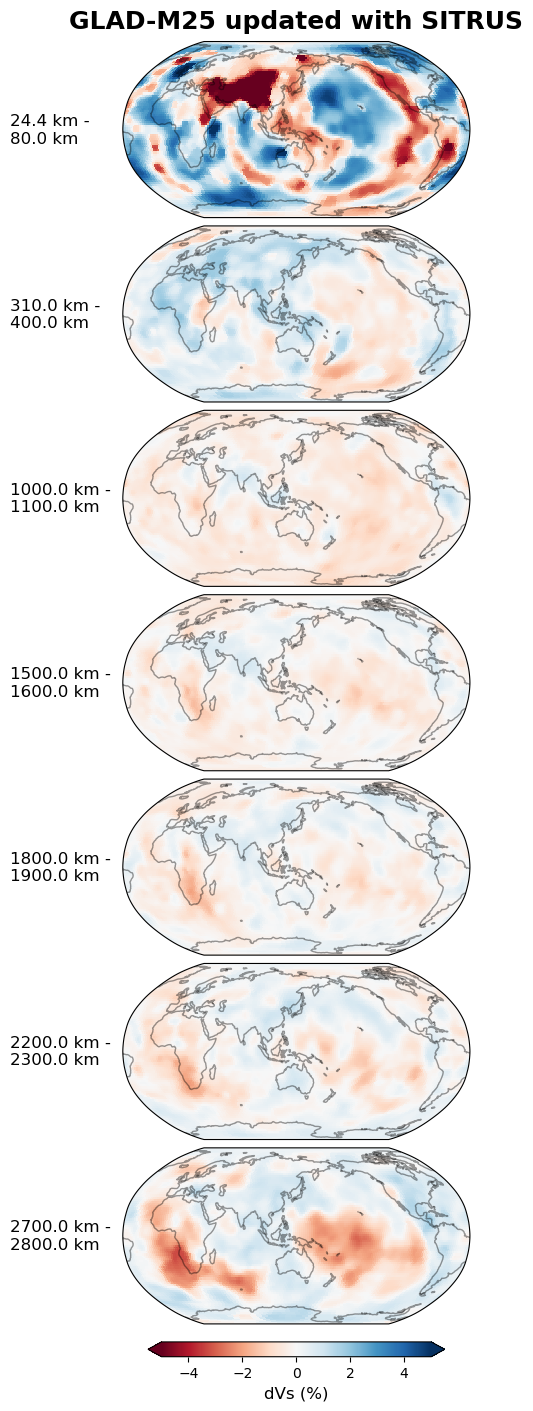

In [5]:
%%time
# define dimensions of the figure and each subplot
fig = plt.figure(figsize = (7.5, 2 * len(shells_to_plot)), constrained_layout = True)
plot_idx = 1

# define the colormap
model_colormap = tomography_colormap

for shell_to_plot in shells_to_plot:
    shell_dims = mod_database.get_shell_info(shell_to_plot)
    shell_top_depth = shell_dims[1]
    shell_bottom_depth = shell_dims[3]

    df_shell = pd.read_csv(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{layer}/{iteration}/{model_to_plot}_updated_model_itr_{iteration.split("_")[-1]}.csv')
    df_shell = df_shell.loc[df_shell['SHELL#'] == shell_to_plot].copy()
    dv = mod_plot.shell_grid_register(df_shell, model_header, plot_increment, plot_increment)

    ax1 = fig.add_subplot(len(shells_to_plot), 1, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax1.set_global()
    im1 = ax1.pcolormesh(lons, lats, dv, shading = 'flat', transform = ccrs.PlateCarree(), cmap = model_colormap, vmin = -bar_val, vmax = bar_val)
    ax1.coastlines(alpha = coastline_transparency)
    if shell_to_plot in shells_to_plot_hotspots:
        lon = df_hotspots.Lon
        lat = df_hotspots.Lat
        sc = ax1.scatter(lon, lat, transform = ccrs.PlateCarree(), s = symbol_size, c = hotspot_color)
    ax1.annotate(f'{shell_top_depth} km - \n{shell_bottom_depth} km', va = 'center', xy = (-0.325, 0.5), xycoords = 'axes fraction', fontsize = 12)
    plot_idx += 1
    
fig.suptitle(f'{model_title}', fontsize = 18, fontweight = 'bold')

# tomography colorbar info:
cbar_tomo = fig.colorbar(im1, orientation = 'horizontal', ax = ax1, shrink = 0.4, pad = 0.1, extend = colorbar_points)
if type_of_model == 'S':
    cbar_tomo.ax.set_xlabel('dVs (%)', size = 12)
elif type_of_model == 'P':
    cbar_tomo.ax.set_xlabel('dVp (%)', size = 12)

if save_png == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_{perturbation_colorbar_max}%_to_{perturbation_colorbar_min}%.png')
if save_svg == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_{perturbation_colorbar_max}%_to_{perturbation_colorbar_min}%.svg')


CPU times: user 41.5 s, sys: 34.7 ms, total: 41.6 s
Wall time: 42.3 s


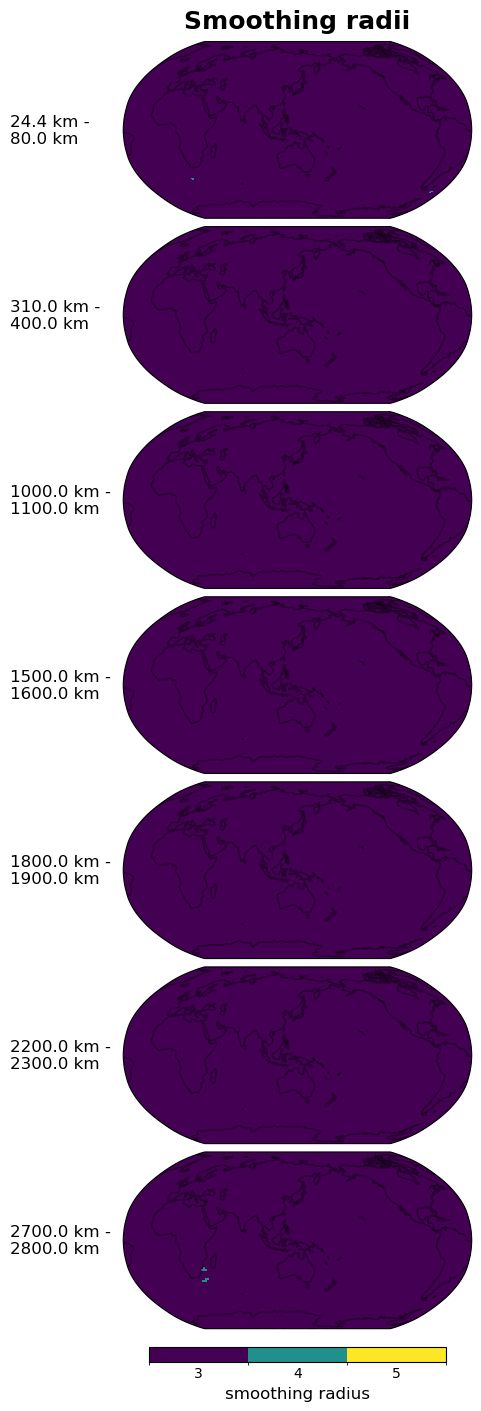

In [6]:
%%time
# define dimensions of the figure and each subplot
fig = plt.figure(figsize = (7.5, 2 * len(shells_to_plot)), constrained_layout = True)
plot_idx = 1
df_radius = pd.read_csv(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{layer}/smoothing_radii.csv')
radii_bins = list(np.sort(df_radius.RADIUS.unique().astype(int)))
max_bar = int(df_radius.RADIUS.unique().max() + 1)
radii_bins.append(max_bar)
rad_norm = mpl.colors.BoundaryNorm(radii_bins, smoothing_radii_colormap.N)

# define the colormap
model_colormap = tomography_colormap

for shell_to_plot in shells_to_plot:
    shell_dims = mod_database.get_shell_info(shell_to_plot)
    shell_top_depth = shell_dims[1]
    shell_bottom_depth = shell_dims[3]

    df_shell = df_radius.loc[df_radius['SHELL#'] == shell_to_plot].copy()
    radii = mod_plot.shell_grid_register(df_shell, 'RADIUS', plot_increment, plot_increment) + 0.11

    ax1 = fig.add_subplot(len(shells_to_plot), 1, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax1.set_global()
    im1 = ax1.pcolormesh(lons, lats, radii, transform = ccrs.PlateCarree(), cmap = smoothing_radii_colormap, norm = rad_norm)
    ax1.coastlines(alpha = coastline_transparency)
    if shell_to_plot in shells_to_plot_hotspots:
        lon = df_hotspots.Lon
        lat = df_hotspots.Lat
        sc = ax1.scatter(lon, lat, transform = ccrs.PlateCarree(), s = symbol_size, c = hotspot_color)
    ax1.annotate(f'{shell_top_depth} km - \n{shell_bottom_depth} km', va = 'center', xy = (-0.325, 0.5), xycoords = 'axes fraction', fontsize = 12)
    plot_idx += 1
    
fig.suptitle(f'Smoothing radii', fontsize = 18, fontweight = 'bold')

# colorbar
rad_cbar_coverage = fig.colorbar(im1, ax = ax1, orientation = 'horizontal', shrink = 0.4, pad = 0.1, extend = 'neither')
rad_cbar_coverage.set_ticks(list(np.array(radii_bins)[:-1] + 0.5))
rad_cbar_coverage.set_ticklabels(radii_bins[:-1])
rad_cbar_coverage.ax.tick_params(labelsize = 10, size = 0)
rad_cbar_coverage.ax.set_xlabel('smoothing radius (deg.)', size = 12);

if save_png == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_smoothing_radii.png')
if save_svg == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_smoothing_radii.svg')

CPU times: user 1min 43s, sys: 722 ms, total: 1min 44s
Wall time: 1min 48s


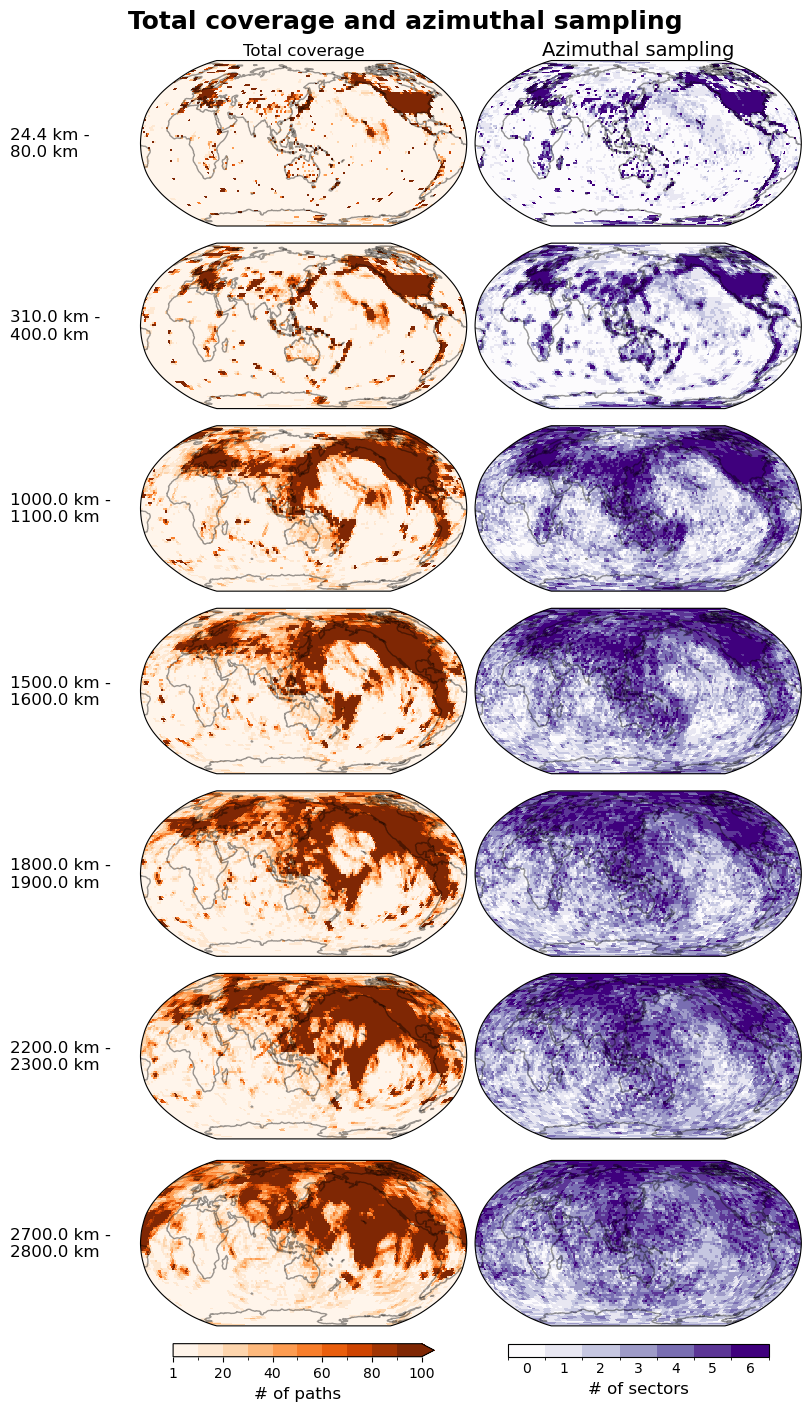

In [7]:
%%time
# define dimensions of the figure and each subplot
fig = plt.figure(figsize = (8, 2 * len(shells_to_plot)), constrained_layout = True)
plot_idx = 1

cov_norm = mpl.colors.BoundaryNorm(total_coverage_bins, coverage_colormap.N)
sector_bins = list(range(0, mod_input.azimuthal_sectors + 2, 1))
sector_norm = mpl.colors.BoundaryNorm(sector_bins, azimuthal_colormap.N)

for shell_to_plot in shells_to_plot:
    shell_dims = mod_database.get_shell_info(shell_to_plot)
    shell_top_depth = shell_dims[1]
    shell_bottom_depth = shell_dims[3]

    tot_cov = mod_plot.shell_coverage_mesh(phases_to_plot, shell_to_plot, 'TOTAL_PATHS', plot_increment, plot_increment)
    az_cov = mod_plot.shell_coverage_mesh(phases_to_plot, shell_to_plot, 'TOTAL_SECTORS', plot_increment, plot_increment)

    ax1 = fig.add_subplot(len(shells_to_plot), 2, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax1.set_global()
    im1 = ax1.pcolormesh(lons, lats, tot_cov, transform = ccrs.PlateCarree(), cmap = coverage_colormap, norm = cov_norm)
    ax1.coastlines(alpha = coastline_transparency)
    if shell_to_plot in shells_to_plot_hotspots:
        lon = df_hotspots.Lon
        lat = df_hotspots.Lat
        sc = ax1.scatter(lon, lat, transform = ccrs.PlateCarree(), s = symbol_size, c = hotspot_color)
    if shell_to_plot == shells_to_plot[0]:
        ax1.annotate(f'Total coverage', ha = 'center', xy = (0.5, 1.03), xycoords = 'axes fraction', fontsize = 12)
    ax1.annotate(f'{shell_top_depth} km -\n{shell_bottom_depth} km', va = 'center', xy = (-0.4, 0.5), xycoords = 'axes fraction', fontsize = 12)
    plot_idx += 1

    ax2 = fig.add_subplot(len(shells_to_plot), 2, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax2.set_global()
    im2 = ax2.pcolormesh(lons, lats, az_cov, transform = ccrs.PlateCarree(), cmap = azimuthal_colormap, norm = sector_norm)
    ax2.coastlines(alpha = coastline_transparency)
    if shell_to_plot in shells_to_plot_hotspots:
        lon = df_hotspots.Lon
        lat = df_hotspots.Lat
        sc = ax1.scatter(lon, lat, transform = ccrs.PlateCarree(), s = symbol_size, c = hotspot_color)
    if shell_to_plot == shells_to_plot[0]:
        ax2.annotate(f'Azimuthal sampling', ha = 'center', xy = (0.5, 1.03), xycoords = 'axes fraction', fontsize = 14)
    plot_idx += 1
    
fig.suptitle(f'Total coverage and azimuthal sampling', fontsize = 18, fontweight = 'bold')

# colorbar info:`
cov_cbar_coverage = fig.colorbar(im1, ax = ax1, orientation = 'horizontal', shrink = 0.8, pad = 0.1, extend = 'max')
cov_cbar_coverage.ax.tick_params(labelsize = 10)
cov_cbar_coverage.ax.set_xlabel('# of paths', size = 12)

sector_cbar_coverage = fig.colorbar(im2, ax = ax2, orientation = 'horizontal', shrink = 0.8, pad = 0.1, extend = 'neither')
sector_cbar_coverage.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
sector_cbar_coverage.set_ticklabels(sector_bins[:-1])
sector_cbar_coverage.ax.tick_params(labelsize = 10, size = 0)
sector_cbar_coverage.ax.set_xlabel('# of sectors', size = 12);

if save_png == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_coverage.png', transparent = True, dpi = 300)
if save_svg == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_coverage.svg')

CPU times: user 1min 32s, sys: 344 ms, total: 1min 32s
Wall time: 1min 34s


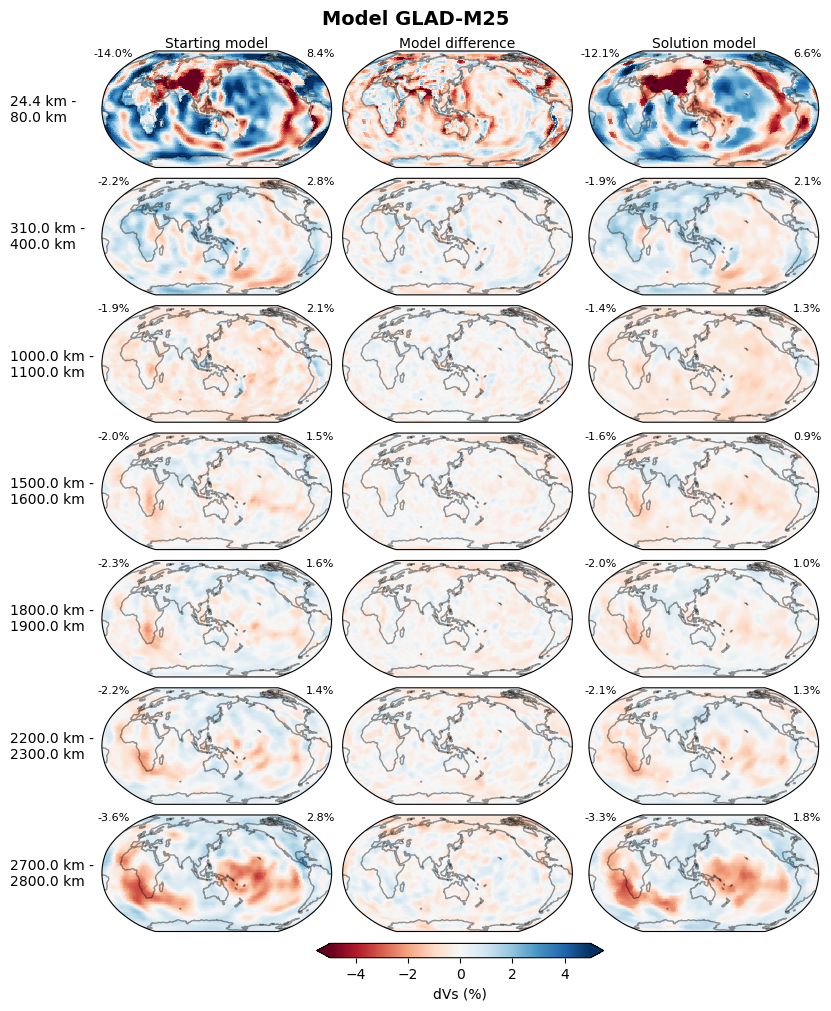

In [8]:
%%time
fig = plt.figure(figsize = (8.2, 10), constrained_layout = True)
plot_idx = 1

for shell in shells_to_plot:
    df_starting_shell = pd.read_csv(f'./models/{type_of_model}/{model_to_plot}_update/{model_to_plot}_grid_registered.csv')
    df_updated_shell = pd.read_csv(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{layer}/{iteration}/{model_to_plot}_updated_model_itr_{iteration.split("_")[-1]}.csv')
    
    df_starting_shell = df_starting_shell.loc[df_starting_shell['SHELL#'] == shell]
    df_updated_shell = df_updated_shell.loc[df_updated_shell['SHELL#'] == shell]

    st_dvs = mod_plot.shell_grid_register(df_starting_shell, model_header, plot_increment, plot_increment)
    up_dvs = mod_plot.shell_grid_register(df_updated_shell, model_header, plot_increment, plot_increment)
    
    diff_dvs = up_dvs - st_dvs
    
    shell_dims = mod_database.get_shell_info(shell)
    shell_top_depth = shell_dims[1]
    shell_bottom_depth = shell_dims[3]
    
    ax1 = fig.add_subplot(len(shells_to_plot), 3, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax1.set_global()
    im1 = ax1.pcolormesh(lons, lats, st_dvs, shading = 'flat', transform = ccrs.PlateCarree(), cmap = tomography_colormap, vmin = -bar_val, vmax = bar_val)
    ax1.coastlines(alpha = coastline_transparency)
    ax1.annotate(f'{shell_top_depth} km -\n{shell_bottom_depth} km', va = 'center', xy = (-0.4, 0.5), xycoords = 'axes fraction', fontsize = 10)
    ax1.annotate(f'{round(np.amin(st_dvs), 1)}%', xy = (0.05, 0.95), ha = 'center', xycoords = 'axes fraction', fontsize = 8)
    ax1.annotate(f'{round(np.amax(st_dvs), 1)}%', xy = (0.95, 0.95), ha = 'center', xycoords = 'axes fraction', fontsize = 8)
    if shell == shells_to_plot[0]:
        ax1.annotate(f'Starting model', ha = 'center', xy = (0.5, 1.03), xycoords = 'axes fraction', fontsize = 10)
    plot_idx += 1

    ax2 = fig.add_subplot(len(shells_to_plot), 3, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax2.set_global()
    im2 = ax2.pcolormesh(lons, lats, diff_dvs, shading = 'flat', transform = ccrs.PlateCarree(), cmap = tomography_colormap, vmin = -bar_val, vmax = bar_val)
    ax2.coastlines(alpha = coastline_transparency)
    if shell == shells_to_plot[0]:
        ax2.annotate(f'Model difference', ha = 'center', xy = (0.5, 1.03), xycoords = 'axes fraction', fontsize = 10)
    plot_idx += 1

    ax3 = fig.add_subplot(len(shells_to_plot), 3, plot_idx, projection = ccrs.Robinson(central_longitude = central_lon))
    ax3.set_global()
    im3 = ax3.pcolormesh(lons, lats, up_dvs, shading = 'flat', transform = ccrs.PlateCarree(), cmap = tomography_colormap, vmin = -bar_val, vmax = bar_val)
    ax3.coastlines(alpha = coastline_transparency)
    ax3.annotate(f'{round(np.amin(up_dvs), 1)}%', xy = (0.05, 0.95), ha = 'center', xycoords = 'axes fraction', fontsize = 8)
    ax3.annotate(f'{round(np.amax(up_dvs), 1)}%', xy = (0.95, 0.95), ha = 'center', xycoords = 'axes fraction', fontsize = 8)
    if shell == shells_to_plot[0]:
        ax3.annotate(f'Solution model', ha = 'center', xy = (0.5, 1.03), xycoords = 'axes fraction', fontsize = 10)
    plot_idx += 1

fig.suptitle(f'Model {model_to_plot.split("_")[0]}', fontsize = 14, fontweight = 'bold')
cbar_tomo = fig.colorbar(im1, ax = [ax1, ax2, ax3], orientation = 'horizontal', shrink = 0.4, pad = 0.1, extend = 'both')
cbar_tomo.ax.tick_params(labelsize = 10)

if type_of_model == 'S':
    cbar_tomo.ax.set_xlabel('dVs (%)', size = 10)
elif type_of_model == 'P':
    cbar_tomo.ax.set_xlabel('dVp (%)', size = 10)
;

if save_png == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_starting_difference_solution_{perturbation_colorbar_max}%_to_{perturbation_colorbar_min}%.png', transparent = True, dpi = 300)
if save_svg == True:
    fig.savefig(f'./models/{type_of_model}/{model_to_plot}_update/{model_pid}_update/{model_to_plot}_starting_difference_solution_{perturbation_colorbar_max}%_to_{perturbation_colorbar_min}%.svg')